## Correlation Analysis of Soil Moisture Data
This notebook performs a correlation between soil moisture measured in the field and several spectral indicesderived from satellite imagery.
The equipment used in the field is a soil monitoring Dr.meter model HG01.

In [106]:
# Import libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import ee
from datetime import datetime, timedelta

In [107]:
# Load the shapefile
shapefile_path = r"c:\field_method\soil_moisture\soil_moisture_sample_points_7sep.shp"
gdf = gpd.read_file(shapefile_path)

In [108]:
# Create a new column for average soil moisture
gdf['Avg_SM'] = gdf[['N', 'S', 'W', 'E', 'C']].mean(axis=1)

# Delete rows with any NaN values in soil moisture columns
gdf_clean = gdf.dropna(subset=['N', 'S', 'W', 'E', 'C'])




### Extracting Spectral Indices using Google Earth Engine
The spectral indices are extracted from Sentinel-2 and Sentinel-1 imagery using Google Earth Engine (GEE). 

From Sentinel 2, the following indices are calculated:

1. *NDMI (Normalized Difference Moisture Index)*: Bands: NIR B8 (10 m), SWIR1 B11 (20 m, resample to 10 m if needed)
Classic canopy/soil moisture proxy; moisture ↑ → NDMI ↑.

2. *MSI (Moisture Stress Index)*: Bands: SWIR1 B11, NIR B8

3. *NMDI (Normalized Multi-band Drought Index)*: Bands: NIR B8, SWIR1 B11, SWIR2 B12. Uses both SWIRs to separate liquid water from other effects; good in crop/soil moisture studies.

From Sentinel 1, the following indices are calculated:

1. *γ⁰_VV (VV backscatter)*: Just the VV channel (linear). In bare or sparsely vegetated soils, higher moisture → higher γ⁰_VV.

2. *γ⁰_VH (VH backscatter)*: Cross-pol is sensitive to surface/veg structure; in many ag/rangeland settings it responds to moisture + roughness.

3. *Polarization Ratio (PR) or NDPI (Normalized Difference Polarization Index)*: Bands: γ⁰_VV, γ⁰_VH. PR = γ⁰_VV / γ⁰_VH; NDPI = (γ⁰_VV - γ⁰_VH) / (γ⁰_VV + γ⁰_VH). Combines info from both polarizations; often more sensitive to moisture changes.


In [109]:
# Look at the data structure first
print("Columns in the dataset:")
print(gdf_clean.columns.tolist())
print("\nFirst few rows:")
print(gdf_clean.head())
print(f"\nShape: {gdf_clean.shape}")

Columns in the dataset:
['fid', 'N', 'S', 'W', 'E', 'C', 'Date', 'geometry', 'Avg_SM']

First few rows:
   fid     N     S     W     E     C       Date                  geometry  \
0  0.0  54.0  33.0  36.0  19.0  54.0 2025-06-29   POINT (9.96521 49.7777)   
1  1.0  49.0  27.0  52.0  52.0  57.0 2025-06-29  POINT (9.96676 49.77433)   
2  2.0  65.0  59.0  52.0  73.0  52.0 2025-06-29  POINT (9.96504 49.77385)   
4  4.0  24.0  35.0  13.0  25.0  28.0 2025-06-29  POINT (9.96692 49.77683)   
6  6.0  62.0  64.0  68.0  47.0  44.0 2025-06-29  POINT (9.96165 49.77087)   

   Avg_SM  
0    39.2  
1    47.4  
2    60.2  
4    25.0  
6    57.0  

Shape: (10, 9)


In [110]:
# Import Google Earth Engine
ee.Authenticate()
ee.Initialize()

In [111]:
# Convert dates to datetime for easier manipulation
gdf_clean['Date_dt'] = pd.to_datetime(gdf_clean['Date'])
min_date = gdf_clean['Date_dt'].min()
max_date = gdf_clean['Date_dt'].max()

print(f"Date range: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")

# Convert points to GEE format with minimal necessary information
gee_features = []
for idx, row in gdf_clean.iterrows():
    # Create point geometry
    point = ee.Geometry.Point([row.geometry.x, row.geometry.y])
    
    # Create feature with only essential properties for GEE processing
    feature = ee.Feature(point, {
        'fid': int(row['fid']),           # Point ID for matching results back
        'date': row['Date']               # Date as string for temporal filtering
        # Note: Soil moisture data stays in pandas dataframe
    })
    gee_features.append(feature)

# Create feature collection
sampling_points_collection = ee.FeatureCollection(gee_features)


# Define the collection date range
# Start date: first sampling date
collection_start_date = min_date.strftime('%Y-%m-%d')


# End date: day after the last sampling date
collection_end_date = (max_date + pd.Timedelta(days=1)).strftime('%Y-%m-%d')

print(f"Sentinel-2 collection date range:")
print(f"Start date: {collection_start_date}")
print(f"End date: {collection_end_date}")

Date range: 2025-06-29 to 2025-06-29
Sentinel-2 collection date range:
Start date: 2025-06-29
End date: 2025-06-30


c:\Users\anugr\miniconda3\envs\gee\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [112]:
# Create AOI from the sampling points (buffered bounding box)
# Get the bounds of all sampling points
aoi = sampling_points_collection.geometry().bounds()
buffer_degrees = 0.001  # approximately 100 meters
aoi_buffered = aoi.buffer(buffer_degrees)

# Create Sentinel-2 Surface Reflectance collection
s2_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                 .filterBounds(aoi_buffered)
                 .filterDate(collection_start_date, collection_end_date)
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)))  # Allow up to 50% clouds for now

# Get collection info
collection_size = s2_collection.size().getInfo()
print(f"Found {collection_size} Sentinel-2 images")

if collection_size > 0:
    # Convert collection to list to access individual images
    image_list = s2_collection.toList(collection_size)
    
    for i in range(collection_size):
        image = ee.Image(image_list.get(i))
        product_id = image.getInfo()['properties'].get('PRODUCT_ID', 'Unknown')
        print(f"{i+1}. {product_id}")
    
else:
    print("No images found!")

Found 1 Sentinel-2 images
1. S2A_MSIL2A_20250629T102701_N0511_R108_T32UNA_20250629T143707
1. S2A_MSIL2A_20250629T102701_N0511_R108_T32UNA_20250629T143707


In [113]:
# Function to calculate spectral indices with cloud masking
def calculate_indices_with_cloud_mask(image):
    """
    Calculate NDMI, MSI, NMDI with cloud/shadow masking
    """
    # Cloud masking using SCL (Scene Classification Layer) band
    scl = image.select('SCL')
    
    # Create mask to exclude clouds, shadows, snow, etc.
    # SCL values to exclude: 3=cloud shadows, 8=medium clouds, 9=high clouds, 10=cirrus, 11=snow/ice
    good_pixels = scl.neq(3).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10)).And(scl.neq(11))
    
    # Get bands
    nir = image.select('B8')      # Near-infrared (10m)
    swir1 = image.select('B11')   # SWIR1 (20m)
    swir2 = image.select('B12')   # SWIR2 (20m)
    
    # Calculate indices
    # NDMI = (NIR - SWIR1) / (NIR + SWIR1)
    ndmi = nir.subtract(swir1).divide(nir.add(swir1)).rename('NDMI')
    
    # MSI = SWIR1 / NIR (higher = more stress)
    msi = swir1.divide(nir).rename('MSI')
    
    # NMDI = (NIR - (SWIR1 - SWIR2)) / (NIR + (SWIR1 - SWIR2))
    nmdi = (nir.subtract(swir1.subtract(swir2))).divide(nir.add(swir1.subtract(swir2))).rename('NMDI')
    
    # Apply cloud mask to all indices
    ndmi_masked = ndmi.updateMask(good_pixels)
    msi_masked = msi.updateMask(good_pixels)
    nmdi_masked = nmdi.updateMask(good_pixels)
    
    return image.addBands([ndmi_masked, msi_masked, nmdi_masked])

In [114]:
# Function to extract indices for each point based on sampling date
def extract_indices_for_points(points_collection, image_collection):
    """
    Extract spectral indices for each point using image from matching date
    """
    results = []
    points_list = points_collection.getInfo()['features']
    
    for point_feature in points_list:
        point_props = point_feature['properties']
        point_geom = ee.Geometry.Point(point_feature['geometry']['coordinates'])
        sampling_date = point_props['date']
        fid = point_props['fid']
        
        # Convert date to proper string format
        if isinstance(sampling_date, dict):
            timestamp = sampling_date['value']
            date_obj = pd.to_datetime(timestamp, unit='ms')
            sampling_date_str = date_obj.strftime('%Y-%m-%d')
        else:
            sampling_date_str = str(sampling_date)
        
        # Create end date for proper date range
        date_obj = pd.to_datetime(sampling_date_str)
        end_date_str = (date_obj + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
        
        # Filter images for this date
        date_filtered = image_collection.filterDate(sampling_date_str, end_date_str)
        
        if date_filtered.size().getInfo() > 0:
            # Get image and calculate indices
            image = date_filtered.first()
            image_with_indices = calculate_indices_with_cloud_mask(image)
            
            # Extract values at this point
            extracted = image_with_indices.select(['NDMI', 'MSI', 'NMDI']).sampleRegions(
                collection=ee.FeatureCollection([ee.Feature(point_geom)]),
                scale=10,
                projection='EPSG:4326'
            )
            
            values = extracted.getInfo()['features'][0]['properties']
            
            results.append({
                'fid': fid,
                'date': sampling_date_str,
                'NDMI': values.get('NDMI', None),
                'MSI': values.get('MSI', None), 
                'NMDI': values.get('NMDI', None)
            })
        else:
            # No image found
            results.append({
                'fid': fid,
                'date': sampling_date_str,
                'NDMI': None,
                'MSI': None,
                'NMDI': None
            })
    
    return results

In [115]:
# Extract spectral indices for all points
print("Extracting spectral indices...")

extraction_results = extract_indices_for_points(sampling_points_collection, s2_collection)
extraction_df = pd.DataFrame(extraction_results)

# Add indices to main dataframe
gdf_clean = gdf_clean.merge(extraction_df[['fid', 'NDMI', 'MSI', 'NMDI']], on='fid', how='left')

# Convert to numeric
gdf_clean['NDMI'] = pd.to_numeric(gdf_clean['NDMI'], errors='coerce')
gdf_clean['MSI'] = pd.to_numeric(gdf_clean['MSI'], errors='coerce')
gdf_clean['NMDI'] = pd.to_numeric(gdf_clean['NMDI'], errors='coerce')

# Show final results
print(f"\nFinal dataset ({len(gdf_clean)} points):")
print(gdf_clean[['fid', 'Date', 'Avg_SM', 'NDMI', 'MSI', 'NMDI']].round(4))

# Summary
valid_data = gdf_clean.dropna(subset=['NDMI', 'MSI', 'NMDI'])
print(f"\nValid data: {len(valid_data)}/{len(gdf_clean)} points")

Extracting spectral indices...

Final dataset (10 points):
    fid       Date  Avg_SM    NDMI     MSI    NMDI
0   0.0 2025-06-29    39.2  0.0833  0.8462  0.4857
1   1.0 2025-06-29    47.4  0.0427  0.9181  0.4037
2   2.0 2025-06-29    60.2  0.1931  0.6763  0.5572
3   4.0 2025-06-29    25.0  0.1177  0.7893  0.4949
4   6.0 2025-06-29    57.0 -0.0271  1.0558  0.4686
5   7.0 2025-06-29    41.4 -0.0268  1.0550  0.5241
6   8.0 2025-06-29    44.0 -0.0716  1.1543  0.4202
7   9.0 2025-06-29    36.4  0.0456  0.9128  0.4216
8  70.0 2025-06-29    34.4  0.0083  0.9836  0.5626
9  71.0 2025-06-29    48.8  0.0736  0.8629  0.4467

Valid data: 10/10 points

Final dataset (10 points):
    fid       Date  Avg_SM    NDMI     MSI    NMDI
0   0.0 2025-06-29    39.2  0.0833  0.8462  0.4857
1   1.0 2025-06-29    47.4  0.0427  0.9181  0.4037
2   2.0 2025-06-29    60.2  0.1931  0.6763  0.5572
3   4.0 2025-06-29    25.0  0.1177  0.7893  0.4949
4   6.0 2025-06-29    57.0 -0.0271  1.0558  0.4686
5   7.0 2025-06-29  

In [116]:
# Create Sentinel-1 collection
s1_collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                 .filterBounds(aoi_buffered)
                 .filterDate(collection_start_date, collection_end_date)
                 .filter(ee.Filter.eq('instrumentMode', 'IW'))
                 .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                 .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')))

collection_size_s1 = s1_collection.size().getInfo()
print(f"Found {collection_size_s1} Sentinel-1 images")

# Function to calculate Sentinel-1 indices
def calculate_s1_indices(image):
    """
    Calculate VV, VH backscatter and NDPI from Sentinel-1
    """
    # Get VV and VH bands (in dB, convert to linear if needed)
    vv = image.select('VV')
    vh = image.select('VH')
    
    # Convert from dB to linear scale for calculations
    vv_linear = ee.Image(10.0).pow(vv.divide(10.0)).rename('VV_linear')
    vh_linear = ee.Image(10.0).pow(vh.divide(10.0)).rename('VH_linear')
    
    # Calculate NDPI (Normalized Difference Polarization Index)
    # NDPI = (VV - VH) / (VV + VH) in linear scale
    ndpi = vv_linear.subtract(vh_linear).divide(vv_linear.add(vh_linear)).rename('NDPI')
    
    # Keep original dB values and add indices
    return image.addBands([vv.rename('VV'), vh.rename('VH'), ndpi])

# Function to extract Sentinel-1 indices
def extract_s1_indices_for_points(points_collection, image_collection):
    """
    Extract Sentinel-1 indices for each point using image from matching date
    """
    results = []
    points_list = points_collection.getInfo()['features']
    
    for point_feature in points_list:
        point_props = point_feature['properties']
        point_geom = ee.Geometry.Point(point_feature['geometry']['coordinates'])
        sampling_date = point_props['date']
        fid = point_props['fid']
        
        # Convert date to proper string format
        if isinstance(sampling_date, dict):
            timestamp = sampling_date['value']
            date_obj = pd.to_datetime(timestamp, unit='ms')
            sampling_date_str = date_obj.strftime('%Y-%m-%d')
        else:
            sampling_date_str = str(sampling_date)
        
        # Create end date for proper date range
        date_obj = pd.to_datetime(sampling_date_str)
        end_date_str = (date_obj + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
        
        # Filter images for this date
        date_filtered = image_collection.filterDate(sampling_date_str, end_date_str)
        
        if date_filtered.size().getInfo() > 0:
            # Get image and calculate indices
            image = date_filtered.first()
            image_with_indices = calculate_s1_indices(image)
            
            # Extract values at this point
            extracted = image_with_indices.select(['VV', 'VH', 'NDPI']).sampleRegions(
                collection=ee.FeatureCollection([ee.Feature(point_geom)]),
                scale=10,
                projection='EPSG:4326'
            )
            
            values = extracted.getInfo()['features'][0]['properties']
            
            results.append({
                'fid': fid,
                'date': sampling_date_str,
                'VV': values.get('VV', None),
                'VH': values.get('VH', None), 
                'NDPI': values.get('NDPI', None)
            })
        else:
            # No image found
            results.append({
                'fid': fid,
                'date': sampling_date_str,
                'VV': None,
                'VH': None,
                'NDPI': None
            })
    
    return results

print(f"Setup complete for Sentinel-1 processing")

Found 1 Sentinel-1 images
Setup complete for Sentinel-1 processing


In [117]:
# Extract Sentinel-1 indices for all points
if collection_size_s1 > 0:
    print("Extracting Sentinel-1 indices...")
    
    s1_extraction_results = extract_s1_indices_for_points(sampling_points_collection, s1_collection)
    s1_extraction_df = pd.DataFrame(s1_extraction_results)
    
    # Add S1 indices to main dataframe
    gdf_clean = gdf_clean.merge(s1_extraction_df[['fid', 'VV', 'VH', 'NDPI']], on='fid', how='left')
    
    # Convert to numeric
    gdf_clean['VV'] = pd.to_numeric(gdf_clean['VV'], errors='coerce')
    gdf_clean['VH'] = pd.to_numeric(gdf_clean['VH'], errors='coerce')
    gdf_clean['NDPI'] = pd.to_numeric(gdf_clean['NDPI'], errors='coerce')
    
    # Show final results with all indices
    print(f"\nFinal dataset with Sentinel-1 and Sentinel-2 indices:")
    display_cols = ['fid', 'Date', 'Avg_SM', 'NDMI', 'MSI', 'NMDI', 'VV', 'VH', 'NDPI']
    print(gdf_clean[display_cols].round(4))
    
    # Summary for both satellites
    s2_valid = gdf_clean.dropna(subset=['NDMI', 'MSI', 'NMDI'])
    s1_valid = gdf_clean.dropna(subset=['VV', 'VH', 'NDPI'])
    both_valid = gdf_clean.dropna(subset=['NDMI', 'MSI', 'NMDI', 'VV', 'VH', 'NDPI'])
    
    print(f"\nData availability:")
    print(f"Sentinel-2 valid: {len(s2_valid)}/{len(gdf_clean)} points")
    print(f"Sentinel-1 valid: {len(s1_valid)}/{len(gdf_clean)} points") 
    print(f"Both satellites valid: {len(both_valid)}/{len(gdf_clean)} points")
else:
    print("No Sentinel-1 images found for the date range")
    # Add empty columns to maintain structure
    gdf_clean['VV'] = np.nan
    gdf_clean['VH'] = np.nan
    gdf_clean['NDPI'] = np.nan

Extracting Sentinel-1 indices...

Final dataset with Sentinel-1 and Sentinel-2 indices:
    fid       Date  Avg_SM    NDMI     MSI    NMDI       VV       VH    NDPI
0   0.0 2025-06-29    39.2  0.0833  0.8462  0.4857   0.8664  -7.4606  0.7437
1   1.0 2025-06-29    47.4  0.0427  0.9181  0.4037  -8.1850 -17.5292  0.7916
2   2.0 2025-06-29    60.2  0.1931  0.6763  0.5572  -7.2275 -14.7997  0.7023
3   4.0 2025-06-29    25.0  0.1177  0.7893  0.4949 -10.1936 -17.7062  0.6988
4   6.0 2025-06-29    57.0 -0.0271  1.0558  0.4686 -13.4375 -13.8406  0.0464
5   7.0 2025-06-29    41.4 -0.0268  1.0550  0.5241 -11.0094 -12.9934  0.2245
6   8.0 2025-06-29    44.0 -0.0716  1.1543  0.4202  -9.3102 -15.1068  0.5832
7   9.0 2025-06-29    36.4  0.0456  0.9128  0.4216 -12.9161 -17.7712  0.5072
8  70.0 2025-06-29    34.4  0.0083  0.9836  0.5626  -3.4223  -8.6139  0.5354
9  71.0 2025-06-29    48.8  0.0736  0.8629  0.4467  -9.5180 -13.6473  0.4426

Data availability:
Sentinel-2 valid: 10/10 points
Sentinel-1 val

## Correlation Analysis and Regression Modeling

This section performs correlation analysis between field-measured soil moisture and satellite-derived indices, followed by linear and exponential regression modeling to establish predictive relationships.

In [120]:
# Additional imports for correlation and regression analysis
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

Complete dataset for analysis: 10 out of 10 points

Correlation Matrix:
        Avg_SM   NDMI    MSI   NMDI     VV     VH   NDPI
Avg_SM   1.000  0.075 -0.037 -0.018 -0.166 -0.022 -0.281
NDMI     0.075  1.000 -0.997  0.339  0.274 -0.109  0.557
MSI     -0.037 -0.997  1.000 -0.318 -0.284  0.098 -0.557
NMDI    -0.018  0.339 -0.318  1.000  0.364  0.521 -0.077
VV      -0.166  0.274 -0.284  0.364  1.000  0.762  0.574
VH      -0.022 -0.109  0.098  0.521  0.762  1.000 -0.084
NDPI    -0.281  0.557 -0.557 -0.077  0.574 -0.084  1.000


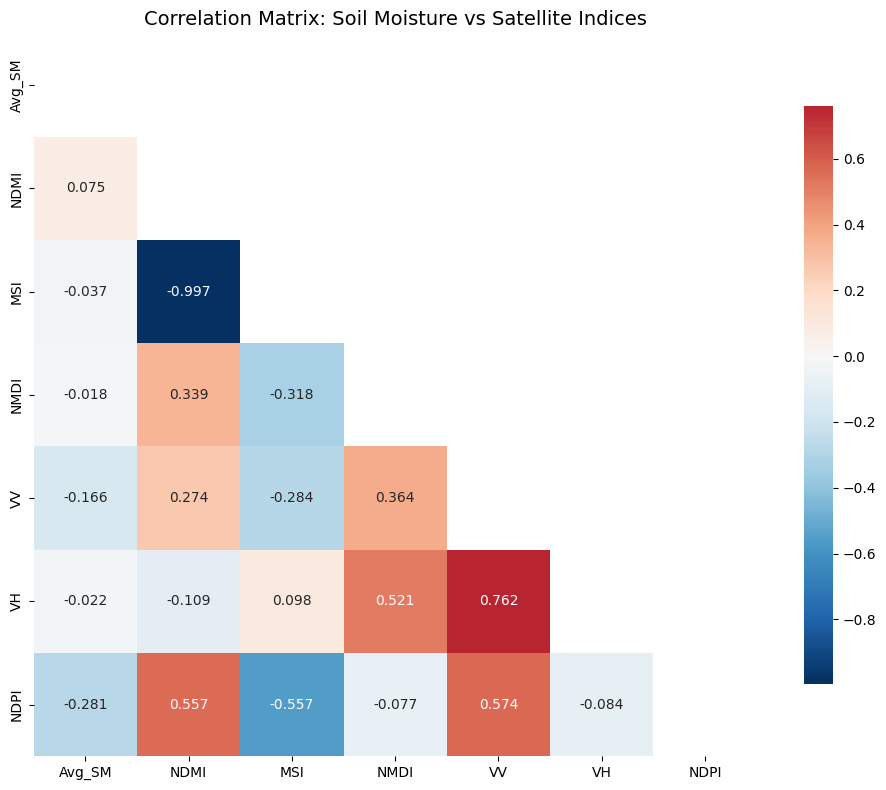


Correlations with Average Soil Moisture:
NDPI  : -0.281
VV    : -0.166
NDMI  :  0.075
MSI   : -0.037
VH    : -0.022
NMDI  : -0.018


In [121]:
# Prepare data for correlation analysis
# Get only complete cases (points with all measurements)
complete_data = gdf_clean.dropna(subset=['Avg_SM', 'NDMI', 'MSI', 'NMDI', 'VV', 'VH', 'NDPI'])

print(f"Complete dataset for analysis: {len(complete_data)} out of {len(gdf_clean)} points")

if len(complete_data) > 0:
    # Calculate correlation matrix
    variables = ['Avg_SM', 'NDMI', 'MSI', 'NMDI', 'VV', 'VH', 'NDPI']
    correlation_matrix = complete_data[variables].corr()
    
    # Display correlation matrix
    print("\nCorrelation Matrix:")
    print(correlation_matrix.round(3))
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.3f',
                cbar_kws={'shrink': 0.8})
    plt.title('Correlation Matrix: Soil Moisture vs Satellite Indices', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print specific correlations with soil moisture
    print(f"\nCorrelations with Average Soil Moisture:")
    soil_moisture_corr = correlation_matrix['Avg_SM'].drop('Avg_SM').sort_values(key=abs, ascending=False)
    for index, corr in soil_moisture_corr.items():
        print(f"{index:6}: {corr:6.3f}")
else:
    print("No complete data available for correlation analysis")

In [122]:
# Define regression analysis functions
def linear_regression_analysis(x, y, var_name):
    """Perform linear regression analysis"""
    # Remove NaN values
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean, y_clean = x[mask], y[mask]
    
    if len(x_clean) < 3:
        return None
        
    # Reshape for sklearn
    X = x_clean.reshape(-1, 1)
    
    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y_clean)
    y_pred = model.predict(X)
    
    # Calculate metrics
    r2 = r2_score(y_clean, y_pred)
    rmse = np.sqrt(mean_squared_error(y_clean, y_pred))
    mae = mean_absolute_error(y_clean, y_pred)
    
    # Calculate correlation coefficient and p-value
    corr_coef, p_value = stats.pearsonr(x_clean, y_clean)
    
    return {
        'variable': var_name,
        'n_points': len(x_clean),
        'slope': model.coef_[0],
        'intercept': model.intercept_,
        'r2': r2,
        'correlation': corr_coef,
        'p_value': p_value,
        'rmse': rmse,
        'mae': mae,
        'x_clean': x_clean,
        'y_clean': y_clean,
        'y_pred': y_pred
    }

def exponential_regression_analysis(x, y, var_name):
    """Perform exponential regression analysis"""
    # Remove NaN values and ensure positive values for log transform
    mask = ~(np.isnan(x) | np.isnan(y)) & (y > 0)
    x_clean, y_clean = x[mask], y[mask]
    
    if len(x_clean) < 3:
        return None
    
    try:
        # Log transform for exponential regression: ln(y) = a + b*x
        log_y = np.log(y_clean)
        
        # Fit linear regression on log-transformed data
        X = x_clean.reshape(-1, 1)
        model = LinearRegression()
        model.fit(X, log_y)
        log_y_pred = model.predict(X)
        
        # Transform back to original scale
        y_pred = np.exp(log_y_pred)
        
        # Calculate metrics on original scale
        r2 = r2_score(y_clean, y_pred)
        rmse = np.sqrt(mean_squared_error(y_clean, y_pred))
        mae = mean_absolute_error(y_clean, y_pred)
        
        # Parameters: y = exp(a + b*x) = exp(a) * exp(b*x)
        a_param = model.intercept_  # ln(A)
        b_param = model.coef_[0]    # B
        A_param = np.exp(a_param)   # A = exp(a)
        
        return {
            'variable': var_name,
            'n_points': len(x_clean),
            'A': A_param,           # y = A * exp(B*x)
            'B': b_param,
            'r2': r2,
            'rmse': rmse,
            'mae': mae,
            'x_clean': x_clean,
            'y_clean': y_clean,
            'y_pred': y_pred
        }
    except:
        return None

print("Regression analysis functions defined")

Regression analysis functions defined


In [123]:
# Perform regression analysis for all satellite indices
if len(complete_data) > 0:
    satellite_indices = ['NDMI', 'MSI', 'NMDI', 'VV', 'VH', 'NDPI']
    
    linear_results = []
    exponential_results = []
    
    print("=== REGRESSION ANALYSIS RESULTS ===\n")
    
    for index in satellite_indices:
        x = complete_data[index].values
        y = complete_data['Avg_SM'].values
        
        # Linear regression
        lin_result = linear_regression_analysis(x, y, index)
        if lin_result:
            linear_results.append(lin_result)
            
        # Exponential regression
        exp_result = exponential_regression_analysis(x, y, index)
        if exp_result:
            exponential_results.append(exp_result)
        
        # Print results for this index
        print(f"--- {index} ---")
        if lin_result:
            print(f"Linear:      R² = {lin_result['r2']:.3f}, RMSE = {lin_result['rmse']:.3f}, p = {lin_result['p_value']:.3f}")
            print(f"             y = {lin_result['slope']:.4f}x + {lin_result['intercept']:.4f}")
        
        if exp_result:
            print(f"Exponential: R² = {exp_result['r2']:.3f}, RMSE = {exp_result['rmse']:.3f}")
            print(f"             y = {exp_result['A']:.4f} * exp({exp_result['B']:.4f}x)")
        print()
    
    # Create summary tables
    if linear_results:
        linear_df = pd.DataFrame([{
            'Index': r['variable'],
            'N': r['n_points'],
            'R²': r['r2'],
            'Correlation': r['correlation'],
            'P-value': r['p_value'],
            'RMSE': r['rmse'],
            'MAE': r['mae'],
            'Slope': r['slope'],
            'Intercept': r['intercept']
        } for r in linear_results])
        
        print("LINEAR REGRESSION SUMMARY:")
        print(linear_df.round(4))
        print()
    
    if exponential_results:
        exponential_df = pd.DataFrame([{
            'Index': r['variable'],
            'N': r['n_points'],
            'R²': r['r2'],
            'RMSE': r['rmse'],
            'MAE': r['mae'],
            'A': r['A'],
            'B': r['B']
        } for r in exponential_results])
        
        print("EXPONENTIAL REGRESSION SUMMARY:")
        print(exponential_df.round(4))
        
else:
    print("Insufficient data for regression analysis")

=== REGRESSION ANALYSIS RESULTS ===

--- NDMI ---
Linear:      R² = 0.006, RMSE = 9.987, p = 0.838
             y = 10.0841x + 42.9376
Exponential: R² = -0.017, RMSE = 10.098
             y = 42.2338 * exp(-0.0398x)

--- MSI ---
Linear:      R² = 0.001, RMSE = 10.008, p = 0.919
             y = -2.7659x + 45.9396
Exponential: R² = -0.020, RMSE = 10.115
             y = 39.0585 * exp(0.0826x)

--- NMDI ---
Linear:      R² = 0.000, RMSE = 10.013, p = 0.960
             y = -3.3915x + 45.0029
Exponential: R² = -0.017, RMSE = 10.101
             y = 49.3015 * exp(-0.3270x)

--- VV ---
Linear:      R² = 0.027, RMSE = 9.876, p = 0.647
             y = -0.4027x + 39.9833
Exponential: R² = 0.012, RMSE = 9.956
             y = 39.4907 * exp(-0.0078x)

--- VH ---
Linear:      R² = 0.000, RMSE = 10.012, p = 0.952
             y = -0.0651x + 42.4726
Exponential: R² = -0.017, RMSE = 10.101
             y = 43.4818 * exp(0.0022x)

--- NDPI ---
Linear:      R² = 0.079, RMSE = 9.611, p = 0.432
       

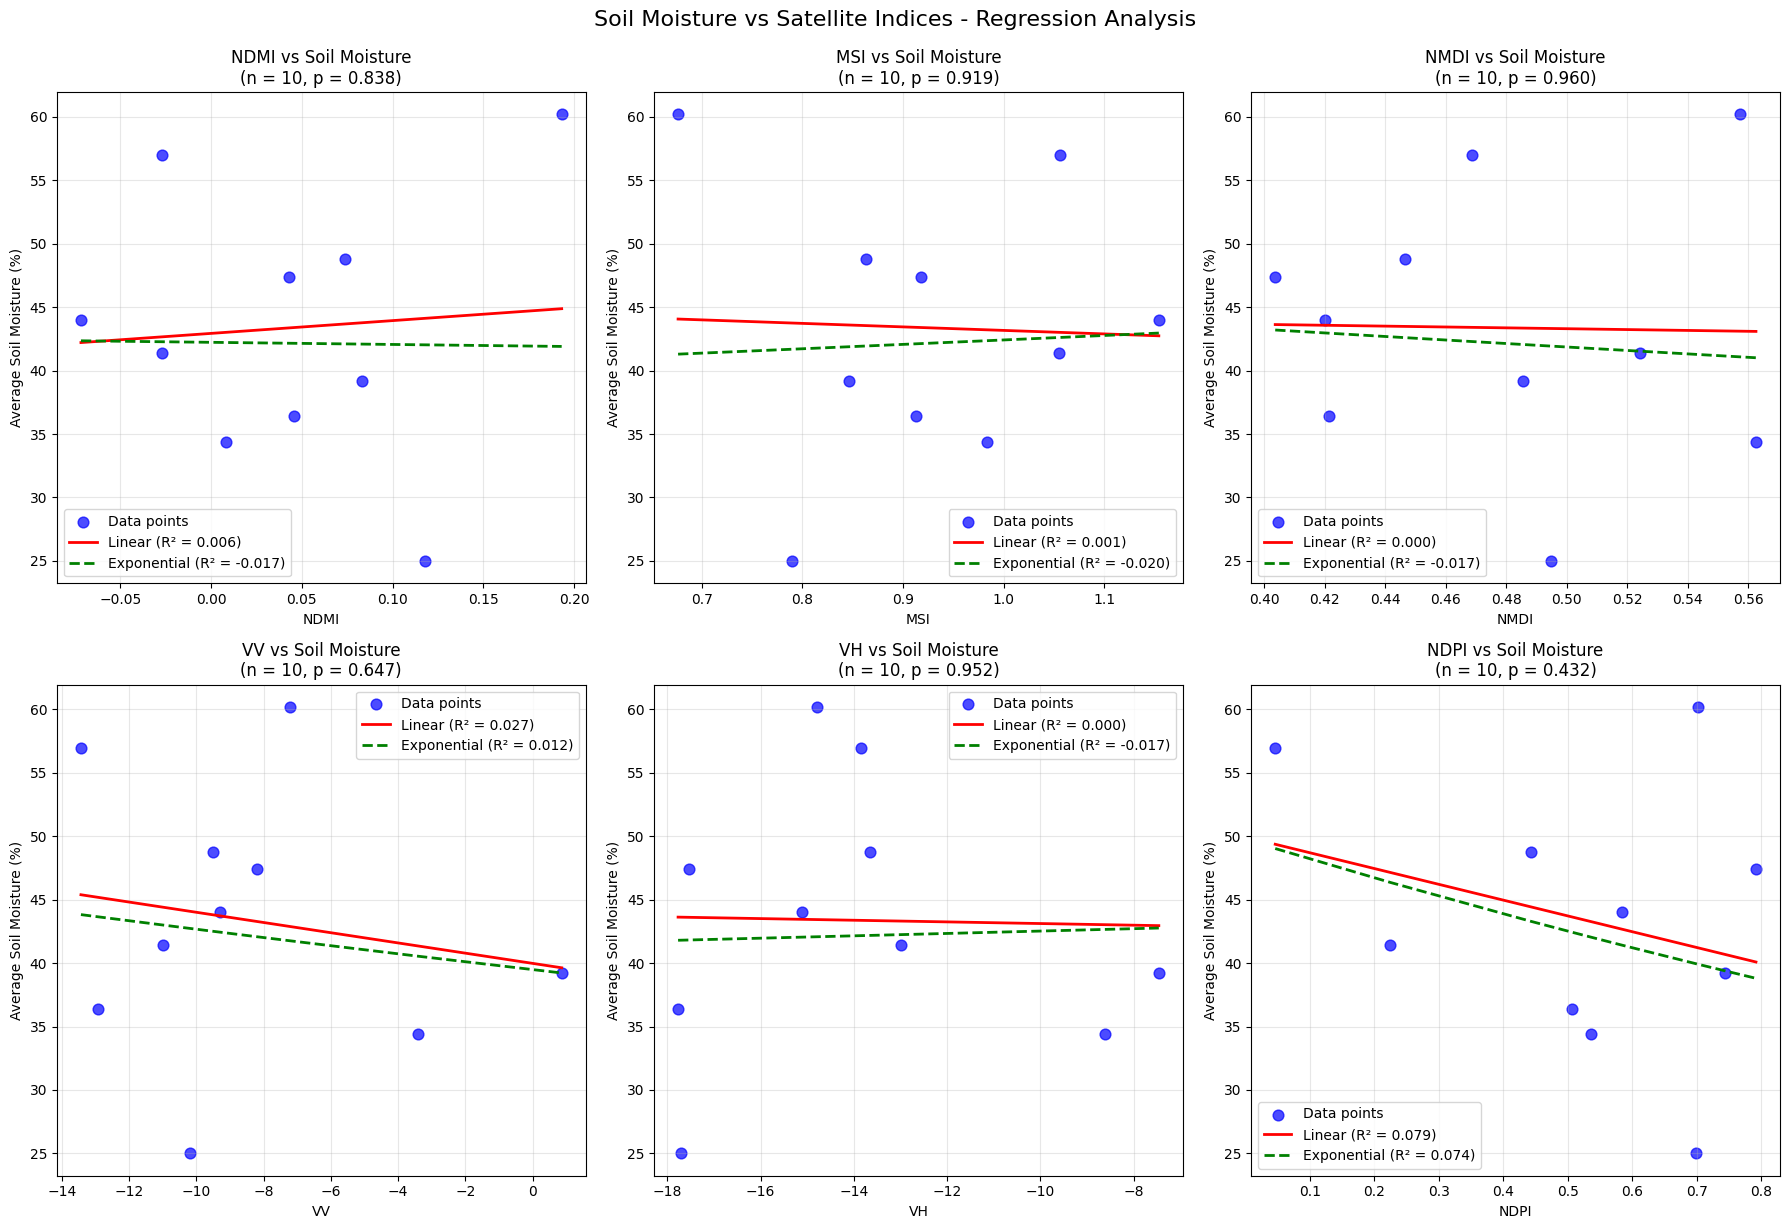

In [124]:
# Create scatter plots with regression lines
if len(complete_data) > 0 and linear_results:
    # Set up the plot grid
    n_indices = len(satellite_indices)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, index in enumerate(satellite_indices):
        ax = axes[i]
        
        # Find corresponding results
        lin_result = next((r for r in linear_results if r['variable'] == index), None)
        exp_result = next((r for r in exponential_results if r['variable'] == index), None)
        
        if lin_result:
            x_clean = lin_result['x_clean']
            y_clean = lin_result['y_clean']
            y_pred_lin = lin_result['y_pred']
            
            # Scatter plot
            ax.scatter(x_clean, y_clean, alpha=0.7, s=60, color='blue', label='Data points')
            
            # Linear regression line
            sort_idx = np.argsort(x_clean)
            ax.plot(x_clean[sort_idx], y_pred_lin[sort_idx], 'r-', linewidth=2, 
                   label=f'Linear (R² = {lin_result["r2"]:.3f})')
            
            # Exponential regression line if available
            if exp_result:
                y_pred_exp = exp_result['y_pred']
                ax.plot(x_clean[sort_idx], y_pred_exp[sort_idx], 'g--', linewidth=2,
                       label=f'Exponential (R² = {exp_result["r2"]:.3f})')
            
            # Formatting
            ax.set_xlabel(f'{index}')
            ax.set_ylabel('Average Soil Moisture (%)')
            ax.set_title(f'{index} vs Soil Moisture\n(n = {lin_result["n_points"]}, p = {lin_result["p_value"]:.3f})')
            ax.legend()
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'No data\navailable for\n{index}', 
                   transform=ax.transAxes, ha='center', va='center', fontsize=12)
            ax.set_title(f'{index} vs Soil Moisture')
    
    plt.tight_layout()
    plt.suptitle('Soil Moisture vs Satellite Indices - Regression Analysis', 
                 fontsize=16, y=1.02)
    plt.show()
else:
    print("No data available for plotting")

In [125]:
# Model comparison and best index identification
if linear_results and exponential_results:
    print("=== MODEL COMPARISON ===\n")
    
    # Compare models for each index
    comparison_results = []
    
    for index in satellite_indices:
        lin_result = next((r for r in linear_results if r['variable'] == index), None)
        exp_result = next((r for r in exponential_results if r['variable'] == index), None)
        
        if lin_result and exp_result:
            better_model = 'Linear' if lin_result['r2'] > exp_result['r2'] else 'Exponential'
            best_r2 = max(lin_result['r2'], exp_result['r2'])
            best_rmse = lin_result['rmse'] if lin_result['r2'] > exp_result['r2'] else exp_result['rmse']
            
            comparison_results.append({
                'Index': index,
                'Linear_R2': lin_result['r2'],
                'Exponential_R2': exp_result['r2'],
                'Best_Model': better_model,
                'Best_R2': best_r2,
                'Best_RMSE': best_rmse,
                'P_value': lin_result['p_value']
            })
    
    if comparison_results:
        comparison_df = pd.DataFrame(comparison_results)
        comparison_df = comparison_df.sort_values('Best_R2', ascending=False)
        
        print("MODEL COMPARISON (sorted by best R²):")
        print(comparison_df.round(4))
        
        # Identify best performing index
        best_index = comparison_df.iloc[0]
        print(f"\n=== BEST PERFORMING INDEX ===")
        print(f"Index: {best_index['Index']}")
        print(f"Best Model: {best_index['Best_Model']}")
        print(f"R²: {best_index['Best_R2']:.4f}")
        print(f"RMSE: {best_index['Best_RMSE']:.4f}")
        print(f"P-value: {best_index['P_value']:.4f}")
        
        # Statistical significance check
        significant_indices = comparison_df[comparison_df['P_value'] < 0.05]
        if len(significant_indices) > 0:
            print(f"\nStatistically significant indices (p < 0.05): {len(significant_indices)}")
            for _, row in significant_indices.iterrows():
                print(f"  {row['Index']}: R² = {row['Best_R2']:.3f}, p = {row['P_value']:.3f}")
        else:
            print("\nNo statistically significant relationships found (p ≥ 0.05)")
            
        # Performance categories
        print(f"\n=== PERFORMANCE CATEGORIES ===")
        excellent = comparison_df[comparison_df['Best_R2'] >= 0.7]
        good = comparison_df[(comparison_df['Best_R2'] >= 0.5) & (comparison_df['Best_R2'] < 0.7)]
        moderate = comparison_df[(comparison_df['Best_R2'] >= 0.3) & (comparison_df['Best_R2'] < 0.5)]
        weak = comparison_df[comparison_df['Best_R2'] < 0.3]
        
        if len(excellent) > 0:
            print(f"Excellent (R² ≥ 0.7): {', '.join(excellent['Index'].values)}")
        if len(good) > 0:
            print(f"Good (0.5 ≤ R² < 0.7): {', '.join(good['Index'].values)}")
        if len(moderate) > 0:
            print(f"Moderate (0.3 ≤ R² < 0.5): {', '.join(moderate['Index'].values)}")
        if len(weak) > 0:
            print(f"Weak (R² < 0.3): {', '.join(weak['Index'].values)}")

else:
    print("Insufficient results for model comparison")

=== MODEL COMPARISON ===

MODEL COMPARISON (sorted by best R²):
  Index  Linear_R2  Exponential_R2 Best_Model  Best_R2  Best_RMSE  P_value
5  NDPI     0.0790          0.0735     Linear   0.0790     9.6110   0.4316
3    VV     0.0275          0.0117     Linear   0.0275     9.8760   0.6472
0  NDMI     0.0056         -0.0168     Linear   0.0056     9.9867   0.8378
1   MSI     0.0014         -0.0202     Linear   0.0014    10.0077   0.9189
4    VH     0.0005         -0.0174     Linear   0.0005    10.0121   0.9518
2  NMDI     0.0003         -0.0173     Linear   0.0003    10.0129   0.9601

=== BEST PERFORMING INDEX ===
Index: NDPI
Best Model: Linear
R²: 0.0790
RMSE: 9.6110
P-value: 0.4316

No statistically significant relationships found (p ≥ 0.05)

=== PERFORMANCE CATEGORIES ===
Weak (R² < 0.3): NDPI, VV, NDMI, MSI, VH, NMDI


In [126]:
# Final summary and data export
print("=== FINAL SUMMARY ===\n")
print(f"Dataset Summary:")
print(f"  Total sampling points: {len(gdf_clean)}")
print(f"  Points with complete data: {len(complete_data) if len(complete_data) > 0 else 0}")
print(f"  Soil moisture range: {gdf_clean['Avg_SM'].min():.1f} - {gdf_clean['Avg_SM'].max():.1f}%")

if len(complete_data) > 0:
    # Save results to CSV for further analysis
    output_file = r"c:\field_method\soil_moisture\soil_moisture_regression_results.csv"
    complete_data[['fid', 'Date', 'Avg_SM', 'NDMI', 'MSI', 'NMDI', 'VV', 'VH', 'NDPI']].to_csv(
        output_file, index=False)
    print(f"\nComplete dataset saved to: {output_file}")
    
    # Recommendations
    print("\n=== RECOMMENDATIONS ===")
    if 'comparison_df' in locals() and len(comparison_df) > 0:
        best_performing = comparison_df.iloc[0]
        if best_performing['Best_R2'] >= 0.5:
            print(f"✓ {best_performing['Index']} shows good predictive capability for soil moisture")
            print(f"  Use {best_performing['Best_Model'].lower()} regression model")
        else:
            print("⚠ No index shows strong predictive capability (R² < 0.5)")
            print("  Consider:")
            print("  - Collecting more data points")
            print("  - Using different indices or combinations")
            print("  - Accounting for additional environmental factors")
            
        # Check for significant relationships
        if 'significant_indices' in locals() and len(significant_indices) > 0:
            print(f"✓ {len(significant_indices)} indices show statistically significant relationships")
        else:
            print("⚠ No statistically significant relationships found")
            print("  This may be due to small sample size or high variability")
    else:
        print("⚠ Analysis could not be completed - insufficient valid data")
        
    print(f"\nFor operational use:")
    print(f"- Minimum sample size: Consider ≥20 points for robust relationships")
    print(f"- Temporal matching: Ensure satellite and field data are from same day")
    print(f"- Quality control: Use cloud masking and data validation")
    
else:
    print("\n⚠ No complete data available for analysis")
    print("Check data quality and temporal matching between field and satellite data")

print(f"\nAnalysis completed successfully! 🚀")

=== FINAL SUMMARY ===

Dataset Summary:
  Total sampling points: 10
  Points with complete data: 10
  Soil moisture range: 25.0 - 60.2%

Complete dataset saved to: c:\field_method\soil_moisture\soil_moisture_regression_results.csv

=== RECOMMENDATIONS ===
⚠ No index shows strong predictive capability (R² < 0.5)
  Consider:
  - Collecting more data points
  - Using different indices or combinations
  - Accounting for additional environmental factors
⚠ No statistically significant relationships found
  This may be due to small sample size or high variability

For operational use:
- Minimum sample size: Consider ≥20 points for robust relationships
- Temporal matching: Ensure satellite and field data are from same day
- Quality control: Use cloud masking and data validation

Analysis completed successfully! 🚀
